In [8]:
from easymocap.mytools.camera_utils import write_camera, read_camera
import numpy as np
import json
import os
# cameras: dict

calib_path = "data/wildtrack/calibs"

cameras = {}

#world_origin_shift = np.array([200,800,0])

for cam_id in range(1, 8):
    with open(os.path.join(calib_path, f'calib_cam{cam_id}.json'), 'r') as f:
        cameras[f'{cam_id}'] = json.load(f)
    
    for key in cameras[f'{cam_id}']:
        if key == "T" :
            cameras[f'{cam_id}'][key] = np.array([cameras[f'{cam_id}'][key]]).T/100
        elif key == "Rvec":
            cameras[f'{cam_id}'][key] = np.array([cameras[f'{cam_id}'][key]]).T
        else:
            cameras[f'{cam_id}'][key] = np.array(cameras[f'{cam_id}'][key])
    cameras[f'{cam_id}']["dist"] = np.zeros((1,5))
path = "data/wildtrack"
write_camera(cameras,path)

In [9]:
cameras = read_camera("data/wildtrack/intri.yml", "data/wildtrack/extri.yml", [1,2,3,4,5,6,7])


[[[  9.09546464]
  [ -5.84390203]
  [  2.88899888]]

 [[ -1.14042221]
  [ 23.77574074]
  [  1.99392533]]

 [[  9.00989324]
  [ 17.71450096]
  [  2.64807244]]

 [[  9.00273068]
  [ -5.84563899]
  [  2.7708962 ]]

 [[ -3.99279403]
  [  9.38078647]
  [  1.68249022]]

 [[ -1.62905086]
  [-10.63834896]
  [  2.24549271]]

 [[ 11.75711579]
  [  1.8746219 ]
  [  3.3953656 ]]]


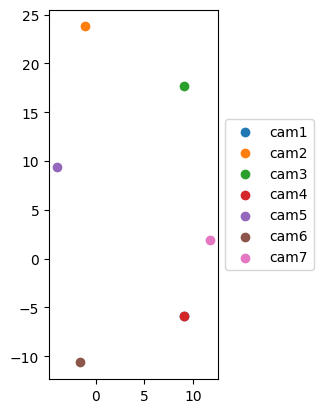

In [11]:

def get_cam_pos(cam_id):
    try:
        R = cameras[f'cam{cam_id}']["R"]
        T = cameras[f'cam{cam_id}']["T"]
    except:
        R = cameras[f'{cam_id}']["R"]
        T = cameras[f'{cam_id}']["T"]
    return -R.T @ T
cam_poses = []
for i in range(1, 8):
    cam_poses.append(get_cam_pos(i))
    
print(np.array(cam_poses))

# show the camera positions from top view
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(7):
    ax.scatter(cam_poses[i][0], cam_poses[i][1], label=f'cam{i+1}')
ax.set_aspect('equal')
# legend on the side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [35]:
from myeasymocap.backbone.hrnet.hrnet import HRNet
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
data_folder = "data/wildtrack"
annot = "data/wildtrack/annotations_positions/"
import os
import json
import pickle



num_joints = 17
model = HRNet(48, num_joints, 0.1)

{'viewNum': 0, 'xmax': 1130, 'xmin': 1066, 'ymax': 395, 'ymin': 169}


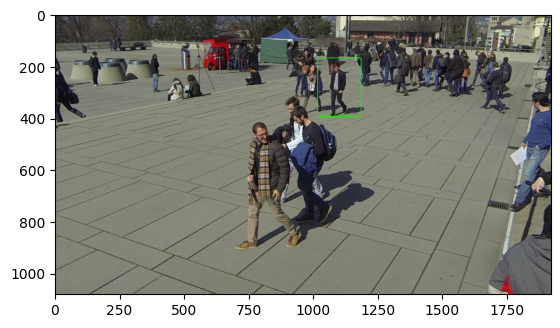

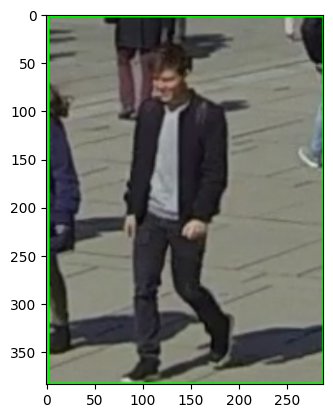

{'output': tensor([[[[ 4.2057e-02,  4.5454e-02,  1.1561e-01,  ...,  3.0224e-03,
             9.3756e-04,  6.0729e-03],
           [ 9.8904e-02,  1.3089e-01,  8.1253e-02,  ...,  4.4284e-03,
             7.5418e-03,  2.4238e-02],
           [ 2.0543e-01,  8.6467e-02,  1.7610e-01,  ...,  5.2131e-02,
             4.4713e-02,  1.7295e-02],
           ...,
           [ 4.5729e-01,  5.3500e-01,  5.6263e-01,  ...,  3.1209e-01,
             2.3220e-01,  2.1550e-01],
           [ 4.5208e-01,  4.7837e-01,  3.3456e-01,  ...,  2.1170e-01,
             1.5708e-01,  1.2847e-01],
           [ 5.9833e-01,  7.1537e-01,  4.4445e-01,  ...,  3.4787e-01,
             3.0331e-01,  2.0276e-01]],
 
          [[ 1.1878e-02,  5.3073e-03,  1.6964e-01,  ...,  8.2432e-02,
             6.1145e-02,  8.2813e-02],
           [ 2.7352e-02,  1.5931e-01,  2.2407e-01,  ...,  8.9694e-02,
             4.7046e-02,  8.3434e-02],
           [ 3.0728e-02,  1.2646e-01,  2.6758e-01,  ...,  4.8856e-02,
             2.7178e-02,  6.0

In [45]:
ckpt ="data/models/pose_hrnet_w48_384x288.pth"
model.load_state_dict(torch.load(ckpt, map_location='cpu'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()



def read_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

def dump(cachename, output):
    os.makedirs(os.path.dirname(cachename), exist_ok=True)
    with open(cachename, 'wb') as f:
        pickle.dump(output, f)
    return output

img_path = "data/wildtrack/images/1/00000000.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

boox_0 = read_json(os.path.join(annot, "00000000.json"))
boox_0 = boox_0[0]['views'][0]
print(boox_0)

xmin, ymin, xmax, ymax = boox_0["xmin"], boox_0["ymin"], boox_0["xmax"], boox_0["ymax"]


aspect_ratio = 288/384 # width/height
w, h = xmax - xmin, ymax - ymin
center = (xmin + w//2, ymin + h//2)
w = h * aspect_ratio
xmin, xmax = center[0] - w//2, center[0] + w//2

xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.imshow(img)
plt.show()


#img = np.zeros((288, 384, 3), dtype=np.uint8)

img = img[ymin:ymax, xmin:xmax]
img = cv2.resize(img, (288, 384))

plt.imshow(img)
plt.show()
img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()
img = img.to(device)
output = model(img)
output

In [20]:


for i in range(300):
    annot_file = os.path.join(annot, f"{i:08d}.json")
    annot_data = read_json(annot_file)
    views = {1 :{}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}}
    for p in annot_data:
        for view in p["views"]:
            view_id = view["viewNum"]
            pid = p["personID"]
            if np.any(np.array([view["xmin"], view["ymin"], view["xmax"], view["ymax"]]) < 0):
                continue
            bbox = np.array([view["xmin"], view["ymin"], view["xmax"], view["ymax"], 0.99, 0, 'person'])
            views[view_id][pid] = bbox
            
    output = f"output/wildtrack/person/{view_id+1}"
    cachename = os.path.join(output, f"{i:06d}.npy") 
    results = []
    res = {
        'results': np.array(persons),
        'image_shape': (1080,1920,3),
    }
    dump(cachename, res)
        

